# **EDS 296 Homework 2: Geospatial Analysis**

### Sadie Cwikiel
#### May 12, 2025

In [1]:
# Load packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


### Model and Variable Selection
The geospatial analysis of the Eastern Tropical Pacific Ocean will be conducted using the following models, scenarios, and variables.

Models:
- CESM2: [add brief description]
- CNRM-ESM2-1: [add brief description]

Scenarios:
- Historical: climate simulation from 1850-2015
- SSP5-8.5: climate simulation from 2015-2100 for worst-case scenario emissions and warming

Variable:
- Sea surface temperature (tos)

### Load and Query the CMIP6 AWS Catalog
Load the CMIP6 database hosted by Amazon Web Services:

In [2]:
# Open the CMIP6 data catalog and store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Convert the catalog to a Pandas dataframe
cat_df = catalog.df

To make this analysis more robust, we will use averages of multiple ensemble members for each model. The following steps, we will select models that have around 10 ensemble members in the historical period and include the variable tos (temperature at ocean surface).

In [3]:
# Specify search terms to query catalog 
# experiment_id: historical 
experiment_ids = ['historical']
# table_id: Ocean
table_id = 'Omon' 
# variable_id: sea surface temperature (tos) 
variable_id = 'tos'

# Extract the part of the catalog that goes with these search terms
res = catalog.search(experiment_id=experiment_ids, table_id=table_id, variable_id=variable_id)

# Find all unique models that ran historical simulations
print(res.df.source_id.unique())

['GFDL-CM4' 'GFDL-ESM4' 'IPSL-CM6A-LR' 'GISS-E2-1-G' 'CNRM-CM6-1'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CNRM-ESM2-1' 'MIROC6' 'AWI-CM-1-1-MR' 'CESM2'
 'SAM0-UNICON' 'GISS-E2-1-H' 'CanESM5' 'CanESM5-CanOE' 'INM-CM4-8'
 'UKESM1-0-LL' 'INM-CM5-0' 'HadGEM3-GC31-LL' 'MPI-ESM-1-2-HAM' 'NESM3'
 'CAMS-CSM1-0' 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'MCM-UA-1-0' 'CESM2-WACCM'
 'NorESM2-LM' 'GISS-E2-1-G-CC' 'MIROC-ES2L' 'E3SM-1-0' 'MRI-ESM2-0'
 'NorCPM1' 'FGOALS-f3-L' 'CNRM-CM6-1-HR' 'FGOALS-g3' 'NorESM2-MM'
 'ACCESS-CM2' 'ACCESS-ESM1-5' 'CESM2-WACCM-FV2' 'CESM2-FV2' 'FIO-ESM-2-0'
 'E3SM-1-1' 'HadGEM3-GC31-MM' 'E3SM-1-1-ECA' 'KACE-1-0-G' 'EC-Earth3-Veg'
 'EC-Earth3' 'AWI-ESM-1-1-LR' 'CIESM' 'CAS-ESM2-0' 'CMCC-CM2-SR5'
 'EC-Earth3-AerChem' 'TaiESM1' 'IPSL-CM5A2-INCA' 'CMCC-CM2-HR4' 'IITM-ESM'
 'EC-Earth3-Veg-LR' 'EC-Earth3-CC' 'CMCC-ESM2' 'IPSL-CM6A-LR-INCA']


Now we loop through all of these models and record how many ensemble members each of them have. 

In [4]:
# source_id: which model do you want? 
source_id = res.df.source_id.unique()

for src in source_id:
    # Print out the name of the model we're working with, to keep track of things
    print(src)
    
    # Extract the part of the catalog that goes with this model
    this_res = catalog.search(experiment_id=experiment_ids, source_id=src, table_id=table_id, variable_id=variable_id)

    # Print the unique member ids
    print(this_res.df.member_id.unique())
    
    # AND/OR print the number of unique members
    print("unique members")
    print(len(this_res.df.member_id.unique()))

GFDL-CM4
['r1i1p1f1']
unique members
1
GFDL-ESM4
['r2i1p1f1' 'r3i1p1f1' 'r1i1p1f1']
unique members
3
IPSL-CM6A-LR
['r3i1p1f1' 'r6i1p1f1' 'r4i1p1f1' 'r14i1p1f1' 'r5i1p1f1' 'r15i1p1f1'
 'r16i1p1f1' 'r27i1p1f1' 'r2i1p1f1' 'r30i1p1f1' 'r28i1p1f1' 'r31i1p1f1'
 'r8i1p1f1' 'r29i1p1f1' 'r9i1p1f1' 'r7i1p1f1' 'r26i1p1f1' 'r20i1p1f1'
 'r23i1p1f1' 'r25i1p1f1' 'r19i1p1f1' 'r21i1p1f1' 'r1i1p1f1' 'r11i1p1f1'
 'r13i1p1f1' 'r10i1p1f1' 'r17i1p1f1' 'r18i1p1f1' 'r22i1p1f1' 'r12i1p1f1'
 'r24i1p1f1' 'r32i1p1f1']
unique members
32
GISS-E2-1-G
['r1i1p1f1' 'r2i1p1f1' 'r5i1p1f1' 'r3i1p1f1' 'r4i1p1f1' 'r7i1p1f1'
 'r6i1p1f1' 'r9i1p1f1' 'r8i1p1f1' 'r10i1p1f1' 'r10i1p3f1' 'r3i1p3f1'
 'r2i1p3f1' 'r5i1p3f1' 'r1i1p3f1' 'r9i1p3f1' 'r4i1p3f1' 'r6i1p3f1'
 'r8i1p3f1' 'r101i1p1f1' 'r102i1p1f1' 'r5i1p1f2' 'r1i1p1f3' 'r4i1p1f3'
 'r5i1p1f3' 'r2i1p1f3' 'r2i1p1f2' 'r6i1p1f2' 'r10i1p1f2' 'r1i1p1f2'
 'r11i1p1f2' 'r8i1p1f2' 'r4i1p1f2' 'r9i1p1f2' 'r3i1p1f3' 'r3i1p1f2'
 'r7i1p1f2' 'r4i1p5f1' 'r10i1p5f1' 'r1i1p5f1' 'r7i1p5f1' 'r3i1p5

CNRM-ESM2-1 and CESM2 both have 11 members (consistent and around our target number of 10), so we will select those models for this analysis. 

### Access Data
Now that we've selected the two models that each have 11 members and the desired variable (tos), we will access the data for each of those models. Once we pull the data for each model, we'll have to loop through each of the ensemble members to verify that the historical and SSP5-8.5 runs have the same ensembles. Then we can extract the data and concatenate the historical and future time series.

**Model 1: CNRM-ESM2-1**

In [26]:
# Model 1: CNRM-ESM2-1

# Extract data just for CNRM-ESM2-1
# Specify search terms to query catalog 
source_id='CNRM-ESM2-1'

# Extract historical data
res_access_hist = catalog.search(experiment_id='historical', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)
# Extract future SSP projection data
res_access_ssp = catalog.search(experiment_id='ssp585', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)


In [27]:
# Print the data frames
print(res_access_hist.df)

print(res_access_ssp.df)

   activity_id institution_id    source_id experiment_id  member_id table_id  \
0         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r1i1p1f2     Omon   
1         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r1i1p1f2     Omon   
2         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r2i1p1f2     Omon   
3         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r2i1p1f2     Omon   
4         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r5i1p1f2     Omon   
5         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r4i1p1f2     Omon   
6         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r3i1p1f2     Omon   
7         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r3i1p1f2     Omon   
8         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical  r10i1p1f2     Omon   
9         CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r6i1p1f2     Omon   
10        CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical   r8i1p1f2     Omon   
11        CMIP   CNRM-CERFACS  CNRM-ESM2

In [28]:
# Make a list of the unique ensemble members
# historical
mems_hist = res_access_hist.df.member_id.unique()
# SSP
mems_ssp = res_access_ssp.df.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

In [24]:
mems_hist

array(['r1i1p1f2', 'r2i1p1f2', 'r5i1p1f2', 'r4i1p1f2', 'r3i1p1f2',
       'r10i1p1f2', 'r6i1p1f2', 'r8i1p1f2', 'r9i1p1f2', 'r7i1p1f2',
       'r11i1p1f2'], dtype=object)

In [23]:
mems_ssp

array(['r3i1p1f2', 'r4i1p1f2', 'r2i1p1f2', 'r5i1p1f2', 'r1i1p1f2'],
      dtype=object)

In [29]:
common_mems

['r4i1p1f2', 'r1i1p1f2', 'r5i1p1f2', 'r2i1p1f2', 'r3i1p1f2']

### The chunk below is where I'm getting the lat indexing error

In [30]:
# Define an empty list for output data
access_data = []

# Retrieve number of members the historical and SSP ensembles have in common
num = len(common_mems)

# Loop over all members-in-common
for mem in range(num):
    # Print statement to keep track of which member we're working on
    print(common_mems[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = res_access_hist.df['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = res_access_hist.df['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = res_access_ssp.df['member_id'] == common_mems[mem]
    ssp_loc = res_access_ssp.df['member_id'][ssp_mask].index[0]
    
    # Extract data from each entry as xarray
    temp_data_hist = xr.open_zarr(res_access_hist.df['zstore'][hist_loc], storage_options={'anon': True})
    temp_data_ssp = xr.open_zarr(res_access_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate the historical and SSP data across the time dimension
    temp_data = xr.concat([temp_data_hist, temp_data_ssp], dim="time")
    
    # Add the concatenated data to a list
    access_data.append(temp_data)

# Concatenate the list into a single xarray object
access_data = xr.concat(access_data, dim="member")

# Store the actual member information as values of the new dimension
access_data = access_data.assign_coords(member=("member", common_mems))


r4i1p1f2
r1i1p1f2


ValueError: 'lat' must have either an index or no index in all datasets, found 1/2 datasets with an index.

In [5]:
# Model 2: CESM2

# Extract data just for CESM2
# Specify search terms to query catalog 
source_id='CESM2'

# Extract historical data
res_access_hist = catalog.search(experiment_id='historical', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)
# Extract future SSP projection data
res_access_ssp = catalog.search(experiment_id='ssp585', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)


In [6]:
# Make a list of the unique ensemble members
# historical
mems_hist = res_access_hist.df.member_id.unique()
# SSP
mems_ssp = res_access_ssp.df.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

In [7]:
common_mems

['r11i1p1f1', 'r10i1p1f1', 'r4i1p1f1']

In [8]:
# Define an empty list for output data
access_data = []

# Retrieve number of members the historical and SSP ensembles have in common
num = len(common_mems)

# Loop over all members-in-common
for mem in range(num):
    # Print statement to keep track of which member we're working on
    print(common_mems[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = res_access_hist.df['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = res_access_hist.df['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = res_access_ssp.df['member_id'] == common_mems[mem]
    ssp_loc = res_access_ssp.df['member_id'][ssp_mask].index[0]
    
    # Extract data from each entry as xarray
    temp_data_hist = xr.open_zarr(res_access_hist.df['zstore'][hist_loc], storage_options={'anon': True})
    temp_data_ssp = xr.open_zarr(res_access_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})

   # Step 1: Reset lat/lon index if they're index coordinates
    for coord in ['lat', 'lon']:
        if coord in temp_data_hist.indexes and coord not in temp_data_hist.dims:
            temp_data_hist = temp_data_hist.reset_index(coord)
        if coord in temp_data_ssp.indexes and coord not in temp_data_ssp.dims:
            temp_data_ssp = temp_data_ssp.reset_index(coord)

    # Step 2: Save lat/lon for later
    lat = temp_data_hist['lat']
    lon = temp_data_hist['lon']

    # Step 3: Drop lat/lon as coords temporarily to avoid concat conflict
    temp_data_hist = temp_data_hist.drop_vars(['lat', 'lon'])
    temp_data_ssp = temp_data_ssp.drop_vars(['lat', 'lon'])

    # Step 4: Concatenate across time
    temp_data = xr.concat([temp_data_hist, temp_data_ssp], dim="time")

    # Step 5: Reassign lat/lon as coordinates
    temp_data = temp_data.assign_coords({'lat': lat, 'lon': lon})
    
    # Add the concatenated data to a list
    access_data.append(temp_data)

# Concatenate the list into a single xarray object
access_data = xr.concat(access_data, dim="member")

# Store the actual member information as values of the new dimension
access_data = access_data.assign_coords(member=("member", common_mems))

r11i1p1f1
r10i1p1f1
r4i1p1f1


/opt/anaconda3/envs/eds296-stevenson/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/anaconda3/envs/eds296-stevenson/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[k

MemoryError: Unable to allocate 3.88 TiB for an array with shape (1, 384, 320, 4, 3013, 180, 2) and data type float64

### Tried to do these steps outside of the same chunk with the loop

In [59]:
temp_data = xr.concat([temp_data_hist, temp_data_ssp], dim="time")

ValueError: 'lat' must have either an index or no index in all datasets, found 1/2 datasets with an index.

In [48]:
 # Add the concatenated data to a list
access_data.append(temp_data)

In [49]:
access_data = xr.concat(access_data, dim="member")

In [10]:
access_data

[<xarray.Dataset>
 Dimensions:    (nlat: 384, nlon: 320, vertices: 4, time: 3012, d2: 2)
 Coordinates:
     lat_bnds   (nlat, nlon, vertices) float32 -79.49 -79.49 ... 72.41 72.41
     lon_bnds   (nlat, nlon, vertices) float32 320.0 321.1 321.1 ... 320.0 319.6
   * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
   * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
   * time       (time) object 1850-01-15 13:00:00 ... 2100-12-15 12:00:00
     time_bnds  (time, d2) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
     lon        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     lat        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
 Dimensions without coordinates: vertices, d2
 Data variables:
     tos        (time, nlat, nlon) float32 dask.array<chunksize=(400, 384, 320), meta=np.ndarray>
 Attributes: (12/48)
     Conventions:            CF-1.7 CMIP-6.2
     activity_id:  

In [54]:
access_data = access_data.assign_coords(member=("member", common_mems))

ValueError: conflicting sizes for dimension 'member': length 3 on 'member' and length 1 on {'nlat': 'lat', 'nlon': 'lat', 'vertices': 'lat_bnds', 'time': 'time', 'd2': 'time_bnds', 'member': 'tos'}

In [39]:
access_data

<xarray.Dataset>
Dimensions:    (lat: 192, member: 3, nbnd: 2, time: 3012, lon: 288)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (member, lat, nbnd, time) float64 -90.0 -90.0 -90.0 ... 90.0 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 -0.625 0.625 0.625 ... 358.1 358.1 359.4
  * time       (time) object 1850-01-15 12:00:00 ... 2100-12-15 12:00:00
    time_bnds  (time, nbnd) object 1850-01-01 00:00:00 ... 2101-01-01 00:00:00
  * member     (member) <U9 'r10i1p1f1' 'r11i1p1f1' 'r4i1p1f1'
Dimensions without coordinates: nbnd
Data variables:
    tas        (member, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  306600.0
    case_id:                24
    ...                     ...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r10i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e47b79db-3925-45a7-9c0a-6799c2f1e8ae...
    version_id:             v20190313

### Trying again with a different model -- seems to work?

In [15]:
# Extract data just for ACCESS-CM2
# Specify search terms to query catalog 
source_id = 'ACCESS-CM2'
table_id = 'Omon'
variable_id = 'tos'

# Extract historical data
res_access_hist = catalog.search(experiment_id='historical', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)
# Extract future SSP projection data
res_access_ssp = catalog.search(experiment_id='ssp370', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)

In [16]:
# Print the data frames
print(res_access_hist.df)

print(res_access_ssp.df)

  activity_id institution_id   source_id experiment_id member_id table_id  \
0        CMIP   CSIRO-ARCCSS  ACCESS-CM2    historical  r1i1p1f1     Omon   
1        CMIP   CSIRO-ARCCSS  ACCESS-CM2    historical  r2i1p1f1     Omon   
2        CMIP   CSIRO-ARCCSS  ACCESS-CM2    historical  r3i1p1f1     Omon   

  variable_id grid_label                                             zstore  \
0         tos         gn  s3://cmip6-pds/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-...   
1         tos         gn  s3://cmip6-pds/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-...   
2         tos         gn  s3://cmip6-pds/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-...   

   dcpp_init_year   version  
0             NaN  20191108  
1             NaN  20191125  
2             NaN  20200306  
   activity_id institution_id   source_id experiment_id member_id table_id  \
0  ScenarioMIP   CSIRO-ARCCSS  ACCESS-CM2        ssp370  r1i1p1f1     Omon   
1  ScenarioMIP   CSIRO-ARCCSS  ACCESS-CM2        ssp370  r2i1p1f1     Omon   
2  ScenarioMIP   CSI

In [17]:
# Make a list of the unique ensemble members
# historical
mems_hist = res_access_hist.df.member_id.unique()
# SSP
mems_ssp = res_access_ssp.df.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

In [18]:
# Define an empty list for output data
access_data = []

# Retrieve number of members the historical and SSP ensembles have in common
num = len(common_mems)

# Loop over all members-in-common
for mem in range(num):
    # Print statement to keep track of which member we're working on
    print(common_mems[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = res_access_hist.df['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = res_access_hist.df['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = res_access_ssp.df['member_id'] == common_mems[mem]
    ssp_loc = res_access_ssp.df['member_id'][ssp_mask].index[0]
    
    # Extract data from each entry as xarray
    temp_data_hist = xr.open_zarr(res_access_hist.df['zstore'][hist_loc], storage_options={'anon': True})
    temp_data_ssp = xr.open_zarr(res_access_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate the historical and SSP data across the time dimension
    temp_data = xr.concat([temp_data_hist, temp_data_ssp], dim="time")
    
    # Add the concatenated data to a list
    access_data.append(temp_data)

# Concatenate the list into a single xarray object
access_data = xr.concat(access_data, dim="member")

# Store the actual member information as values of the new dimension
access_data = access_data.assign_coords(member=("member", common_mems))

r1i1p1f1
r3i1p1f1
r2i1p1f1


In [86]:
access_data

<xarray.Dataset>
Dimensions:             (i: 360, j: 300, time: 3012, bnds: 2, member: 3,
                         vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 293 294 295 296 297 298 299
    latitude            (j, i) float64 -77.88 -77.88 -77.88 ... 65.63 65.21
    longitude           (j, i) float64 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12...
    time_bnds           (time, bnds) datetime64[ns] 1850-01-01 ... 2101-01-01
  * member              (member) <U8 'r3i1p1f1' 'r2i1p1f1' 'r1i1p1f1'
Dimensions without coordinates: bnds, vertices
Data variables:
    tos                 (member, time, j, i) float32 dask.array<chunksize=(1, 202, 300, 360), meta=np.ndarray>
    vertices_latitude   (member, time, j, i, vertices) float64 dask.array<chunksize=(1, 1980, 300, 360, 4), meta=np.ndarray>
    vertices_longitude  (member, time, j, i, vertices) float64 dask.array<chunksize=(1, 1980, 300, 360, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36524.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/cb26ff83-05b4-462f-8e82-0ec0b8c8d094
    variable_id:            tos
    variant_label:          r3i1p1f1
    version:                v20200306
    netcdf_tracking_ids:    hdl:21.14100/cb26ff83-05b4-462f-8e82-0ec0b8c8d094
    version_id:             v20200306

### Region of Interest: Eastern Tropical Pacific Ocean
The eastern tropical Pacific Ocean (ETP) is one of the most productive regions in the world, due in part to the high levels of nutrients brought to the surface via upwelling. This productivity results in some of the most important fisheries in the world, including for multiple species of tuna, anchovies, and sardines. The ETP is characterized by cool ocean temperatures due to the Humboldt Current that brings cold water north from Antarctica, as well as the upwelling of deep, cold water along the equator and coast of South America. 

The region is highly impacted by El Niño Southern Oscillation (ENSO). During El Niño events, ocean temperatures are warmer and upwelling is dampened. The reduction in upwelling leads to a decline in primary productivity that cascades up the foodweb, often causing crashes in fisheries production. During La Niña events, the opposite occurs. 

In future climate scenarios, we might expect the ocean temperatures to warm in the region, likely resulting in shifts of marine species distributions in order for organisms to stay within their prefered conditions. Additionally, there is evidence that El Niño events may increase in the future, which could lead to more frequent disruptions to marine ecosystems due to the increase in temperature and decline in net primary production during those events. 

**Select data in ETP region**


In [19]:
# Define min/max bounds for region of interest
lat_min, lat_max = -10, 10
lon_min, lon_max = 200, 290 

In [20]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
#j = lat, i = lon
tos_ACCESS_CM2_lat = (access_data.j >= lat_min) & (access_data.j <= lat_max)
tos_ACCESS_CM2_lon = (access_data.i >= lon_min) & (access_data.i <= lon_max)

# Find points where the mask value is True, drop all other points
tos_ACCESS_CM2 = access_data.where(tos_ACCESS_CM2_lat & tos_ACCESS_CM2_lon, drop=True)


/opt/anaconda3/envs/eds296-stevenson/lib/python3.8/site-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [88]:
tos_ACCESS_CM2

<xarray.Dataset>
Dimensions:             (member: 3, time: 3012, j: 6, i: 51, vertices: 4,
                         bnds: 2)
Coordinates:
  * i                   (i) int32 225 226 227 228 229 ... 271 272 273 274 275
  * j                   (j) int32 0 1 2 3 4 5
    latitude            (j, i) float64 -77.88 -77.88 -77.88 ... -76.63 -76.63
    longitude           (j, i) float64 305.5 306.5 307.5 ... 353.5 354.5 355.5
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12...
    time_bnds           (time, bnds) datetime64[ns] 1850-01-01 ... 2101-01-01
  * member              (member) <U8 'r3i1p1f1' 'r2i1p1f1' 'r1i1p1f1'
Dimensions without coordinates: vertices, bnds
Data variables:
    tos                 (member, time, j, i) float32 dask.array<chunksize=(1, 202, 6, 51), meta=np.ndarray>
    vertices_latitude   (member, time, j, i, vertices) float64 dask.array<chunksize=(1, 1980, 6, 51, 4), meta=np.ndarray>
    vertices_longitude  (member, time, j, i, vertices) float64 dask.array<chunksize=(1, 1980, 6, 51, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36524.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/cb26ff83-05b4-462f-8e82-0ec0b8c8d094
    variable_id:            tos
    variant_label:          r3i1p1f1
    version:                v20200306
    netcdf_tracking_ids:    hdl:21.14100/cb26ff83-05b4-462f-8e82-0ec0b8c8d094
    version_id:             v20200306

### Time Periods of Interest

Average sea surface temperature in the ETP across the following early and late time periods will be analyzed:
- Early: 1970-2000
- Late: 2070-2100

These time periods were chosen to explore the potential climate changes experienced over 100 years of industrialized emissions. By the 1970s, it was generally established that anthropogenic emission of greenhouse gases could irreparably alter the climate system. By comparing these two time periods, we can compare the warming that may be experienced from when anthropogenic climate change was starting to be described through the end of the century. Each of the time periods is 30 years long in order to calculate the average climatologies 100 years apart to account for interannual and interdecadal climate variability. 

In [21]:
## Select time periods

# Get data for an earlier period: 20th century
data_early = tos_ACCESS_CM2.sel(time=slice("1870-01-01", "1900-12-31"))

# Get data for a later period: 21st century
data_late = tos_ACCESS_CM2.sel(time=slice("2070-01-01", "2100-12-31"))

In [22]:
# Take the time average for each time period
data_early_mn = data_early.mean(dim="time")
data_late_mn = data_late.mean(dim="time")

In [112]:
data_early_mn

<xarray.Dataset>
Dimensions:             (member: 3, j: 0, i: 0, vertices: 4)
Coordinates:
  * i                   (i) int32 
  * j                   (j) int32 
    latitude            (j, i) float64 
    longitude           (j, i) float64 
  * member              (member) <U8 'r3i1p1f1' 'r2i1p1f1' 'r1i1p1f1'
Dimensions without coordinates: vertices
Data variables:
    tos                 (member, j, i) float32 dask.array<chunksize=(1, 0, 0), meta=np.ndarray>
    vertices_latitude   (member, j, i, vertices) float64 dask.array<chunksize=(1, 0, 0, 4), meta=np.ndarray>
    vertices_longitude  (member, j, i, vertices) float64 dask.array<chunksize=(1, 0, 0, 4), meta=np.ndarray>

In [23]:
# Extract the values into Numpy arrays to make them easier to work with
tos_early = data_early_mn.tos.values
tos_late = data_late_mn.tos.values

In [24]:
#loop through each combination of latitude and longitude
#then calculate the significance of differences between our two samples at every point
# Define empty output arrays
# T-test
tos_pvals_t = np.empty((len(data_early_mn.j), len(data_early_mn.i)))
# Rank-sum test
tos_pvals_rs = np.empty((len(data_early_mn.j), len(data_early_mn.i)))

# Loop over lat, lon in the Numpy array
for latidx in range(len(data_early_mn.j)):
    for lonidx in range(len(data_early_mn.i)):
        # Run test on each grid point
        # T-test
        ttest = stats.ttest_ind(tos_early[:,latidx, lonidx], tos_late[:, latidx, lonidx])
        # Rank-sum
        stat_rs, pval_rs = stats.ranksums(tos_early[:,latidx, lonidx], tos_late[:, latidx, lonidx])
        
        # Save results in the output array
        tos_pvals_rs[latidx, lonidx] = pval_rs
        tos_pvals_t[latidx, lonidx] = ttest.pvalue

### Map of Average Temp Over Each Time Period

##### **Early Time Period (1970-2000)**

### Next issue -- all nan's, can't figure out where it goes wrong

In [27]:
tos_early

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)

In [135]:
data_early_mn

<xarray.Dataset>
Dimensions:             (member: 3, j: 11, i: 91, vertices: 4)
Coordinates:
  * i                   (i) int32 200 201 202 203 204 ... 286 287 288 289 290
  * j                   (j) int32 0 1 2 3 4 5 6 7 8 9 10
    latitude            (j, i) float64 -77.88 -77.88 -77.88 ... -75.29 -75.29
    longitude           (j, i) float64 280.5 281.5 282.5 283.5 ... 8.5 9.5 10.5
  * member              (member) <U8 'r3i1p1f1' 'r2i1p1f1' 'r1i1p1f1'
Dimensions without coordinates: vertices
Data variables:
    tos                 (member, j, i) float32 dask.array<chunksize=(1, 11, 91), meta=np.ndarray>
    vertices_latitude   (member, j, i, vertices) float64 dask.array<chunksize=(1, 11, 91, 4), meta=np.ndarray>
    vertices_longitude  (member, j, i, vertices) float64 dask.array<chunksize=(1, 11, 91, 4), meta=np.ndarray>

TypeError: cannot directly convert an xarray.Dataset into a numpy array. Instead, create an xarray.DataArray first, either with indexing on the Dataset or by invoking the `to_array()` method.

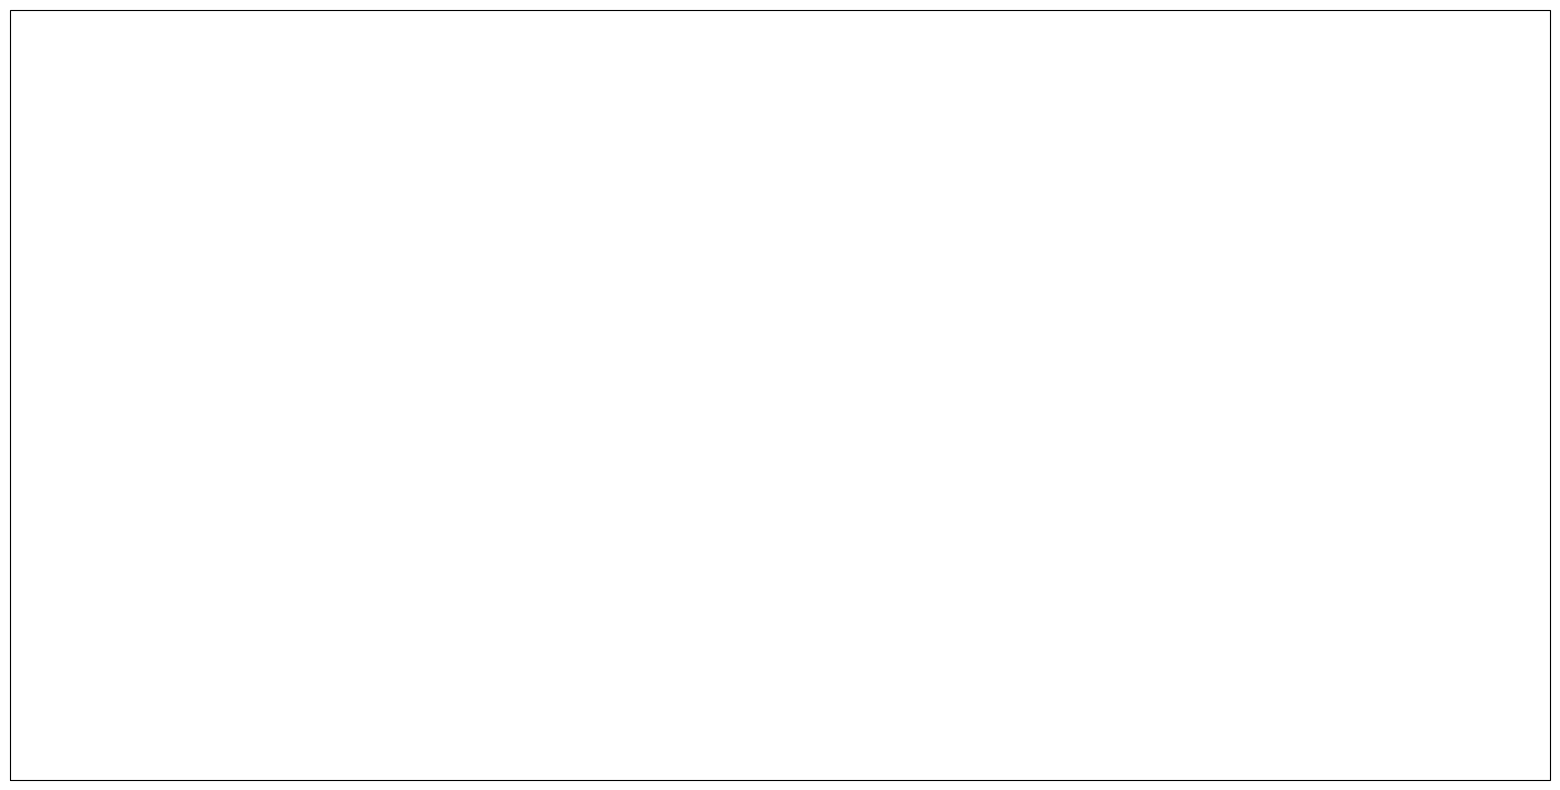

In [26]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn.i, data_early_mn.j, data_early_mn, 
                     transform=map, cmap="BrBG", vmin=0, vmax=5)

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Sea surface temperature (C)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}


# Statistical significance for historical vs future precip change regressed on gradient change
#latitudes, longitudes = np.where(tos_pvals_rs < 0.05)
#lats = data_early_mn.coords['j'][latitudes].values
#lons = data_early_mn.coords['i'][longitudes].values
#ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

# Add title, show plot
ax.set_title("Sea surface temperature", fontsize= 20)
plt.show()


##### **Late Time Period (2070-2100)**

### Map of Difference Between the Two Time Periods

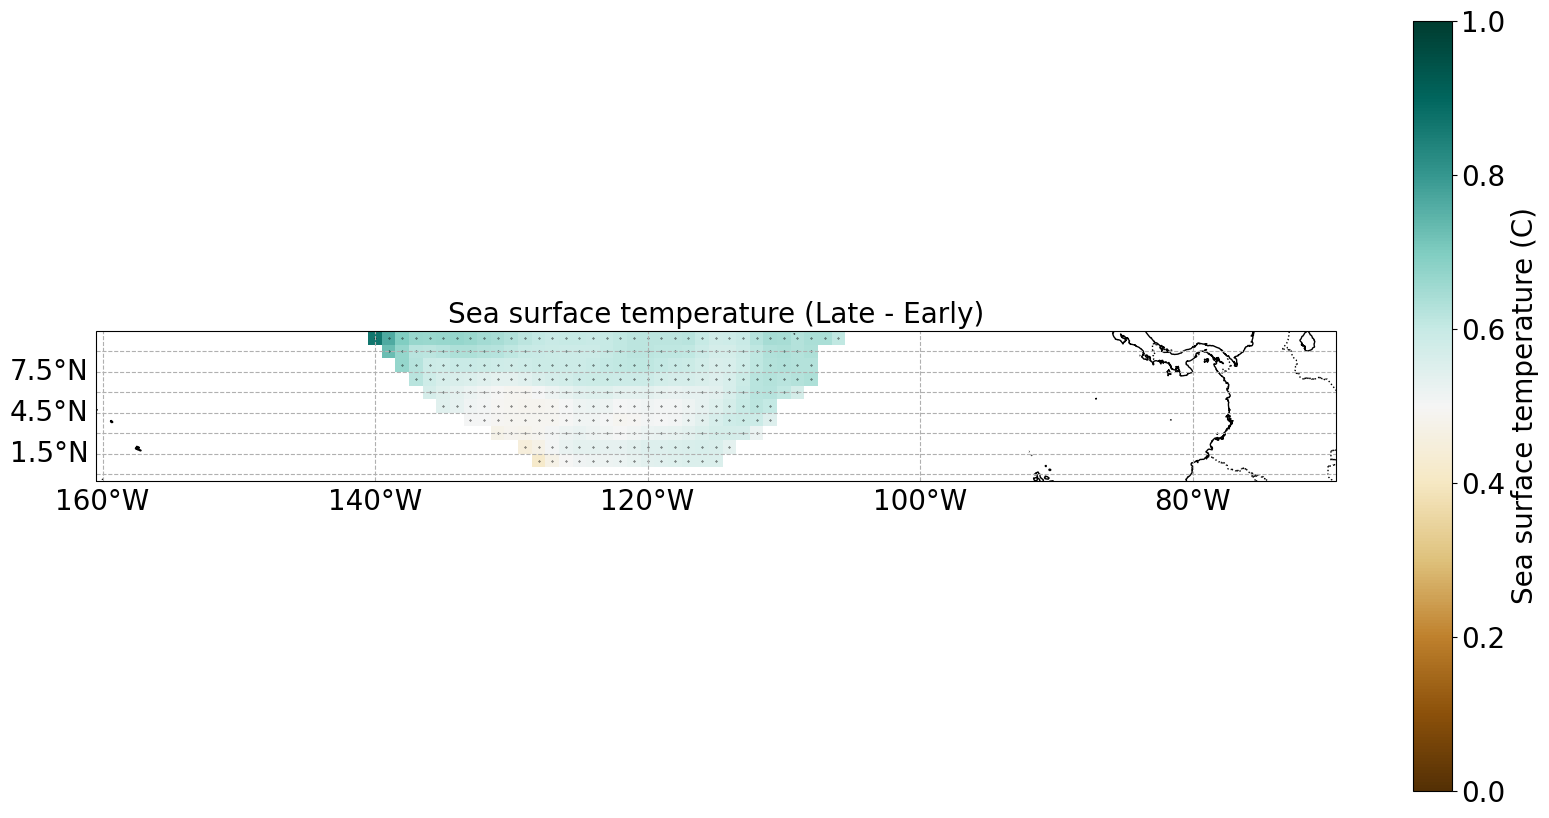

In [124]:
# Calculate ensemble-mean epoch difference
ensmn_diff = tos_late.mean(axis=0) - tos_early.mean(axis=0)

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn.i, data_early_mn.j, ensmn_diff, 
                     transform=map, cmap="BrBG", vmin=0, vmax=1)

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Sea surface temperature (C)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}


# Statistical significance for historical vs future precip change regressed on gradient change
latitudes, longitudes = np.where(tos_pvals_rs < 0.05)
lats = data_early_mn.coords['j'][latitudes].values
lons = data_early_mn.coords['i'][longitudes].values
ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

# Add title, show plot
ax.set_title("Sea surface temperature (Late - Early)", fontsize= 20)
plt.show()


### Results